# Research with pipelines



This tutorial demonstrate how to work with pipeline in Research.

### Imports and Utilities

We start with some useful imports and constant definitions

In [1]:
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../../..')

import matplotlib.pyplot as plt
%matplotlib inline

from batchflow import Pipeline, B, C, V, D
from batchflow.opensets import MNIST
from batchflow.research import Research, Domain, E
from batchflow.models.torch import VGG7, VGG16
from batchflow.models.metrics import Loss

In [2]:
BATCH_SIZE = 64
ITERATIONS = 1000

## Single-experiment Research

First we define a simple pipeline that loads some MNIST data and trains VGG7 model on it. It also saves the loss on each iteration in a pipeline variable. Let's call it an experiment.

### Loading Data and Creating Pipeline

We call a lazy version of pipeline's run method to define batch size to use. We pass `n_epochs=None`, because the duration of our experiment will be controlled by Research.

In [3]:
mnist = MNIST()

model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
}

train_template = (Pipeline()
            .init_variable('loss')
            .init_model('conv', VGG7, 'dynamic', config=model_config)
            .to_array(channels='first')
            .train_model('conv', images=B('images'), targets=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

### Creating Research

The simpliest thing we can do with Research is running this experiment several times to see how loss dynamics changes from run to run.

To do this we define a `Research` object, pass the number of experiment iterations `n_reps=4` via initialization and add the pipeline with `add_pipeline`, passing `train_ppl`. The `variables` parameter gets a string or a list of strings that indicates which pipeline variables will be monitored by `Research` and written to research results on each iteration (note that we update loss variable with mode `'w'`). We also provide name that will be written to results, indicating their origin.

In [4]:
research = (Research(n_reps=4)
    .add_pipeline('train_ppl', train_ppl, variables='loss')
)

### Running Research

We run this Research with following parameters:
    
- `n_iters` - how many iterations will the experiment consist of. Each iteration here consists of processing a single batch
- `name` - research name, also acts as a name for corresponding save folder
- `bar` - toggles tqdm progress bar
- `dump_results` - not to dump research results

In [5]:
research.run(name='research', n_iters=ITERATIONS, bar=True, dump_results=False)

100%|██████████| 4000/4000 [02:59<00:00, 22.29it/s]


### Investigating Research Results

Let's investigate `pandas.DataFrame` representtation of research results.

In [6]:
results = research.results.to_df(remove_auxilary=False)
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          4000 non-null   object 
 1   repetition  4000 non-null   int64  
 2   updates     4000 non-null   int64  
 3   device      0 non-null      object 
 4   iteration   4000 non-null   int64  
 5   loss        4000 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 218.8+ KB


To see the experiments' results we call `to_df` method which returns `pandas.Dataframe` of 6 columns:
- id — unique id for each experiment
- repetition — experiment repetition number
- updates - the number of domain updates before that experiment (idea will be described in the following tutorials)
- device - the device value that was set for the experiment
- iteration — experiment iteration number
- loss — variable name passed earlier in add_pipeline

In [7]:
results.sample(10)

,id,repetition,updates,device,iteration,loss
3393,13f3061b56734291,3,0,None,393,0.057052
118,b8c9f03190607674,0,0,None,118,0.038573
2528,b80801d336392332,2,0,None,528,0.014264
3232,13f3061b56734291,3,0,None,232,0.069171
1334,d7fc81d090382818,1,0,None,334,0.061397
2898,b80801d336392332,2,0,None,898,0.024384
1303,d7fc81d090382818,1,0,None,303,0.106389
1266,d7fc81d090382818,1,0,None,266,0.035564
841,b8c9f03190607674,0,0,None,841,0.029711
3852,13f3061b56734291,3,0,None,852,0.090864


We can now draw a nice plot showing our loss dynamics on each experiment repetition.

<AxesSubplot:xlabel='iteration'>

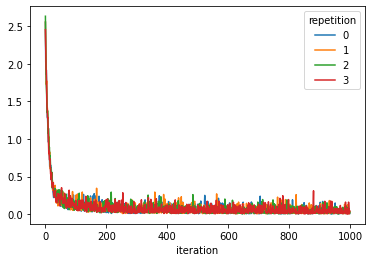

In [8]:
results.pivot(index='iteration', columns='repetition', values='loss').plot()

## Experiments with Domain

`Domain` was descibed in the previous tutorials and here we use to run several experiments with different parameters in one research. Suppose we want to compare the performance of:
- VGG7 and VGG16 models with different layouts ('convolution-normalization-activation' vs 'convolution-activation-normalization') and same default bias and pool_strides settings (which are no bias and 2)
- VGG7 with pool_stride 1 and VGG16 with pool_stride 2, both with bias and default 'cna' layout

We define a domain of parameters as follows. We define a `Domain` that consists of the parameter to vary and a list of values that we want to try in our research. Each parameter value defines a node in a parameter domain. We can add (`+`) domains to unite the nodes, multiply (`*`) them to get Cartesian product and also multiply domain options node-wise (`@`).

`domain.iterator` is a generator that yields one node (that is, a single experiment specification) at a time. Printing a list of all nodes shows us all experiment modifications in a dict-like mode.

In [9]:
domain_1 = Domain(layout=['cna', 'can'], model=[VGG7, VGG16], bias=[False], stride=[2])
domain_2 = (Domain(layout=['cna'], bias=[True])
            * (Domain(model=[VGG7, VGG16]) @ Domain(stride=[1, 2])))
domain = domain_1 + domain_2
list(domain.iterator)

[{'bias': 'False',
  'layout': 'cna',
  'model': 'VGG7',
  'repetition': '0',
  'stride': '2',
  'updates': '0'},
 {'bias': 'False',
  'layout': 'cna',
  'model': 'VGG16',
  'repetition': '0',
  'stride': '2',
  'updates': '0'},
 {'bias': 'False',
  'layout': 'can',
  'model': 'VGG7',
  'repetition': '0',
  'stride': '2',
  'updates': '0'},
 {'bias': 'False',
  'layout': 'can',
  'model': 'VGG16',
  'repetition': '0',
  'stride': '2',
  'updates': '0'},
 {'bias': 'True',
  'layout': 'cna',
  'model': 'VGG7',
  'repetition': '0',
  'stride': '1',
  'updates': '0'},
 {'bias': 'True',
  'layout': 'cna',
  'model': 'VGG16',
  'repetition': '0',
  'stride': '2',
  'updates': '0'}]

Resulting configs have `'repetition'`, `'device'` and `'updates'` keys (descibed above). By default there is an one only repetition but it can be specified by `n_reps` parameters of Domain (see [tutorial 2](https://github.com/analysiscenter/batchflow/blob/research/examples/tutorials/research/02_domain.ipynb))

### Creating Pipelines With Variable Parameters

We should now update `model_config` so that it could read the values from domain defined above.
Passing config option named expressions `C()` as parameters values with names from our parameter domain we define layout, `pool_strides` and `bias` in the model config. Then, we define model type passing named expression to `init_model` method of the pipeline.

In [10]:
model_config.update({
    'body/block/layout': C('layout'),
    'body/block/pool_strides': C('stride'),
    'common/conv/bias': C('bias')
})

# For reference: previous train_template definition 
# train_template = (Pipeline()
#             .init_variable('loss')
#             .init_model('conv', VGG7, 'dynamic', config=model_config)
#             .to_array(channels='first')
#             .train_model('conv', images=B('images'), targets=B('labels'),
#                          fetches='loss', save_to=V('loss', mode='w'))
#             .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_template = (Pipeline()
            .init_variable('loss', default=[])
            .init_model('conv', C('model'), 'dynamic', config=model_config) # Model class defined via named expression
            .to_array(channels='first')
            .train_model('conv', 
                         images=B('images'), targets=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

### Adding Domain To Research

We define a new research as before but also add the domain of parameters. After that we run the research, and it takes much longer because we are now running 6 different experiments 2 times each beacuse we set `n_reps=2`.

In [11]:
research = (Research(domain=domain, n_reps=2)
            .add_pipeline('train', train_ppl, variables='loss'))

research.run(n_iters=ITERATIONS, bar=True, dump_results=False)

100%|██████████| 12000/12000 [09:45<00:00, 20.51it/s]


Research results now contain new columns `'layout'`, `'stride'`, `'bias'` and `'model'` with corresponding parameter values.

In [12]:
results = research.results.to_df(remove_auxilary=False)
results.head()

,id,layout,model,bias,stride,repetition,updates,device,iteration,loss
0,e9846ea006215739,cna,<class 'batchflow.models.torch.vgg.VGG7'>,False,2,0,0,None,0,2.628799
1,e9846ea006215739,cna,<class 'batchflow.models.torch.vgg.VGG7'>,False,2,0,0,None,1,2.330719
2,e9846ea006215739,cna,<class 'batchflow.models.torch.vgg.VGG7'>,False,2,0,0,None,2,1.997086
3,e9846ea006215739,cna,<class 'batchflow.models.torch.vgg.VGG7'>,False,2,0,0,None,3,1.796379
4,e9846ea006215739,cna,<class 'batchflow.models.torch.vgg.VGG7'>,False,2,0,0,None,4,1.753498


## Controlling `to_df` output

### Loading Results With Single-column Config Representation

To combine different config options in a single-column string representation we can pass `concat_config=True` to `to_df` method.

In [13]:
results = research.results.to_df(concat_config=True, remove_auxilary=False)
results.head()

,id,config,repetition,updates,device,iteration,loss
0,e9846ea006215739,bias_False-layout_cna-model_VGG7-stride_2,0,0,None,0,2.628799
1,e9846ea006215739,bias_False-layout_cna-model_VGG7-stride_2,0,0,None,1,2.330719
2,e9846ea006215739,bias_False-layout_cna-model_VGG7-stride_2,0,0,None,2,1.997086
3,e9846ea006215739,bias_False-layout_cna-model_VGG7-stride_2,0,0,None,3,1.796379
4,e9846ea006215739,bias_False-layout_cna-model_VGG7-stride_2,0,0,None,4,1.753498


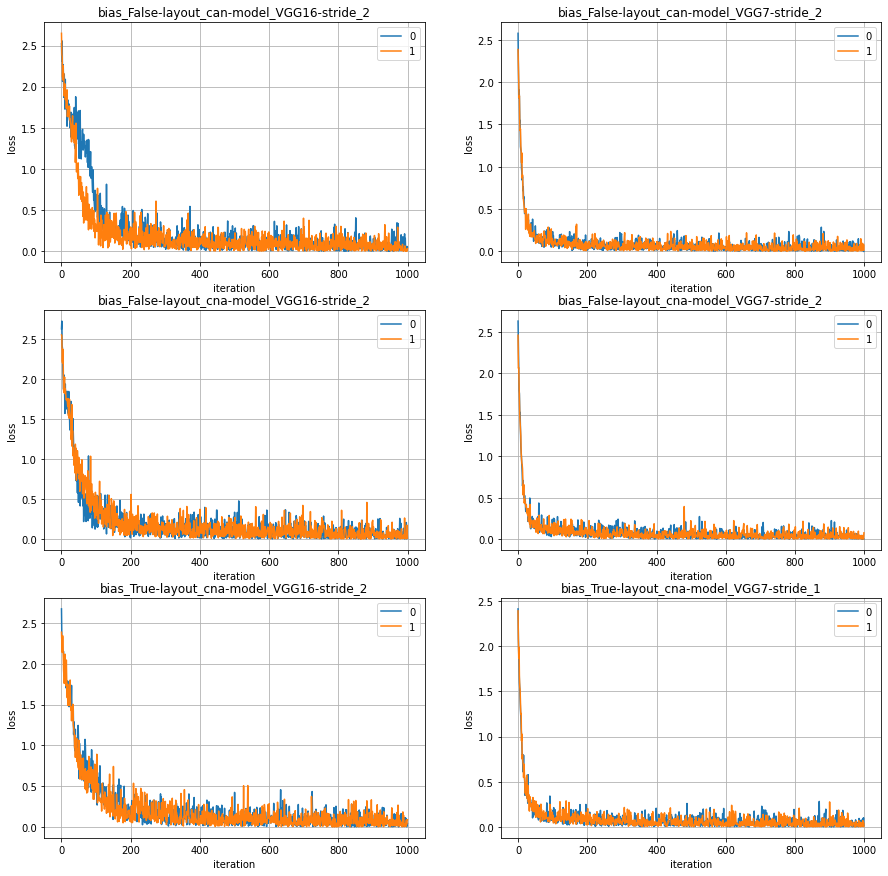

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, (config, df) in enumerate(results.groupby('config')):
    x, y = i//2, i%2
    df.pivot(index='iteration', columns='repetition', values='loss').plot(ax=ax[x, y])
    ax[x, y].set_title(config)
    ax[x, y].set_xlabel('iteration')
    ax[x, y].set_ylabel('loss')
    ax[x, y].grid(True)
    ax[x, y].legend()

## More Complex Execution Strategies

Usually we would like to run more than a single unit like train pipeline.

Let's define a test pipeline to that predicts labels for the test set with the model from the train pipeline on the last iteration of the research.

### Creating Research with Multiple Pipelines

We start with defining a train pipeline as before.

In [15]:
domain = Domain(layout=['cna', 'can'])

model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('conv', VGG7, 'dynamic', config=model_config)
            .to_array(channels='first')
            .train_model('conv', 
                         images=B('images'), targets=B('labels'),
                         fetches='loss', save_to=V('train_loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

We want to run the test pipeline on the whole test set from time to time during training.

In order to get this, we specify lazy-run in test pipeline with `n_epochs=1` and then pass `run=True` to research's `add_pipeline`. These 2 parameter values tell `Research` to run the pipeline on the whole test set for 1 epoch, instead of running it batch-wise (which is how the train pipeline is run). We will also pass `when='last'` parameter to add_pipeline to tell `Research` that this pipeline should be executed only on the last iteration.

To avoid experiment iteration stopping directly after `StopIteration` in `train_ppl` we also add `finalize=True`. In that case, `test_ppl` with `when='last'` will be executed.

To let the test pipeline using the model from train pipeline we'll pass it via `C('import_from')`, setting it's value when creating Research.
We update the pipeline variable `V('predictions')` with mode='a' so that it collects infomation from all batches in `test_ppl`

In [16]:
test_template = (Pipeline()
                 .init_variable('predictions', default=list())
                 .import_model('conv', C('import_from'))
                 .to_array(channels='first')
                 .predict_model('conv', 
                                images=B('images'),
                                fetches='predictions', save_to=V('predictions', mode='a'))
                 .run_later(BATCH_SIZE, shuffle=False, n_epochs=1) #Note n_epochs=1
                )

test_ppl = test_template << mnist.test

In [17]:
TEST_EXECUTE_FREQ = 'last'

res_name = 'train_test_research'

research = (Research(domain=domain)
            .add_pipeline('train_ppl', train_ppl, variables='train_loss')
            .add_pipeline('test_ppl', test_ppl, variables='predictions',
                          when=TEST_EXECUTE_FREQ, run=True,
                          import_from=E('train_ppl'))) # Note run=True

research.run(n_iters=ITERATIONS, name=res_name, dump_results=False, bar=True)

100%|██████████| 2000/2000 [01:28<00:00, 22.70it/s]


In [18]:
research.results.df.tail()

,id,layout,iteration,train_loss,predictions
1995,63d398aa34940289,can,995,0.014158,[]
1996,63d398aa34940289,can,996,0.039048,[]
1997,63d398aa34940289,can,997,0.009655,[]
1998,63d398aa34940289,can,998,0.039730,[]
1999,63d398aa34940289,can,999,0.035299,"[[[-4.4296875, -1.8964844, -0.70410156, -1.757..."


## Getting metrics

There is a special research util method `get_metrics` for collecting metrics.

In [19]:
from batchflow.research.utils import get_metrics

First we redefine the test pipeline and add variables to store predictions and metrics computed for these predictions via gather_metrics.

We update `V('predictions')` with default mode `mode='w'`, that is overwrite it on each `test_ppl` iteration, because we need it only to compute metrics. We update `V('metrics')` with `mode='a'` because we want it to keep metrics from all batches in `test_ppl`.

In [20]:
TEST_EXECUTE_FREQ = [100, 'last']

test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array(channels='first')
                 .predict_model('conv', 
                                images=B('images'),
                                fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=1, save_to=V('metrics', mode='a'))
                 .run_later(BATCH_SIZE, shuffle=True, n_epochs=1))

test_ppl = test_template << mnist.test

### Collecting Metrics in Research

We pass test pipeline name to collect metrics from it (`pipeline='test_ppl'`), named expression storing collected metrics (`metrics_var='metrics'`) and string indicating which metric to calculate (`metrics_name='accuracy'`). We also change `loglevel` to `'info'`.

In [21]:
research = (Research(domain=domain)
            .add_pipeline('train_ppl', train_ppl, variables='train_loss')
            .add_pipeline('test_ppl', test_ppl,
                          when=TEST_EXECUTE_FREQ, run=True, import_from=E('train_ppl'))
            .get_metrics(pipeline=E('test_ppl').pipeline, metrics_var='metrics',
                         metrics_name='accuracy', save_to='accuracy',
                         when=TEST_EXECUTE_FREQ)
)

research.run(n_iters=ITERATIONS, dump_results=False, loglevel='info', bar=False)

21-07-05 12:14:03 - research - INFO - Research is starting
21-07-05 12:14:03 - research - INFO - Get 1 tasks with 1 configs, remains 1
21-07-05 12:14:03 - research - INFO - Start workers (parallel=True)
21-07-05 12:14:03 - research - INFO - Worker 0[pid:2345] has started.
21-07-05 12:14:03 - research - INFO - Worker 0[pid:2345] have got task 0.
21-07-05 12:14:03 - research.ef9a9d3146463506 - INFO - Task 0[0] has been started with config:
 {'id': 'ef9a9d3146463506', 'layout': 'cna', 'repetition': '0', 'updates': '0'}
21-07-05 12:14:03 - research.ef9a9d3146463506 - INFO - Task 0[0] has been started with config:
 {'id': 'ef9a9d3146463506', 'layout': 'cna', 'repetition': '0', 'updates': '0'}
21-07-05 12:14:57 - research.ef9a9d3146463506 - INFO - Task 0[0] has been finished.
21-07-05 12:14:57 - research.ef9a9d3146463506 - INFO - Task 0[0] has been finished.
21-07-05 12:14:58 - research - INFO - Get 1 tasks with 1 configs, remains 0
21-07-05 12:14:58 - research - INFO - Worker 0[pid:2345] ha

In [22]:
research.results.to_df(pivot=True, iterations=49)

,id,layout,iteration,train_loss,accuracy
0,ef9a9d3146463506,cna,49,0.144394,NaN
1,63d398aa73371889,can,49,0.126469,NaN


### Collecting Test Loss In Research

In order to monitor test loss one can use Metrics machinery. We add `gather_metrics` of type `'loss'` and pass current loss and batch size.

In [23]:
test_template = (Pipeline()
                .init_variable('loss')
                .init_variable('predictions')
                .init_variable('test_loss')
                .init_variable('metric_class')
                .import_model('conv', C('import_from'))
                .to_array(channels='first')
                .predict_model('conv', 
                               images=B.images, labels=B.labels,
                               fetches=['loss', 'predictions'],
                               save_to=[V('loss'), V('predictions')])
                .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=1, save_to=V('metric_class', mode='a'))
                .gather_metrics('loss', loss=V('loss'), batch_len=B.images.shape[0], save_to=V('test_loss', mode='a'))
                .run_later(BATCH_SIZE, n_epochs=1, shuffle=False)
)

test_ppl = test_template << mnist.test

We collect test loss in research as before

In [24]:
research = (Research(domain=domain)
            .add_pipeline('train_ppl', train_ppl, variables='train_loss')
            .add_pipeline('test_ppl', test_ppl,
                          when=TEST_EXECUTE_FREQ, run=True, import_from=E('train_ppl'))
            .get_metrics(pipeline=E('test_ppl').pipeline, metrics_var='metrics',
                         metrics_name='accuracy', save_to='accuracy',
                         when=TEST_EXECUTE_FREQ)
            .get_metrics(pipeline=E('test_ppl').pipeline, metrics_var='test_loss',
                         metrics_name='loss', save_to='test_loss',
                         when=TEST_EXECUTE_FREQ)
)

research.run(n_iters=ITERATIONS, dump_results=False, loglevel='info', bar=False)

21-07-05 12:15:59 - research - INFO - Research is starting
21-07-05 12:15:59 - research - INFO - Research is starting
21-07-05 12:15:59 - research - INFO - Get 1 tasks with 1 configs, remains 1
21-07-05 12:15:59 - research - INFO - Get 1 tasks with 1 configs, remains 1
21-07-05 12:15:59 - research - INFO - Start workers (parallel=True)
21-07-05 12:15:59 - research - INFO - Start workers (parallel=True)
21-07-05 12:15:59 - research - INFO - Worker 0[pid:12873] has started.
21-07-05 12:15:59 - research - INFO - Worker 0[pid:12873] has started.
21-07-05 12:15:59 - research - INFO - Worker 0[pid:12873] have got task 0.
21-07-05 12:15:59 - research - INFO - Worker 0[pid:12873] have got task 0.
21-07-05 12:15:59 - research.ef9a9d3141743150 - INFO - Task 0[0] has been started with config:
 {'id': 'ef9a9d3141743150', 'layout': 'cna', 'repetition': '0', 'updates': '0'}
21-07-05 12:15:59 - research.ef9a9d3141743150 - INFO - Task 0[0] has been started with config:
 {'id': 'ef9a9d3141743150', 'lay

In [25]:
df = research.results.to_df(remove_auxilary=False, concat_config=True)

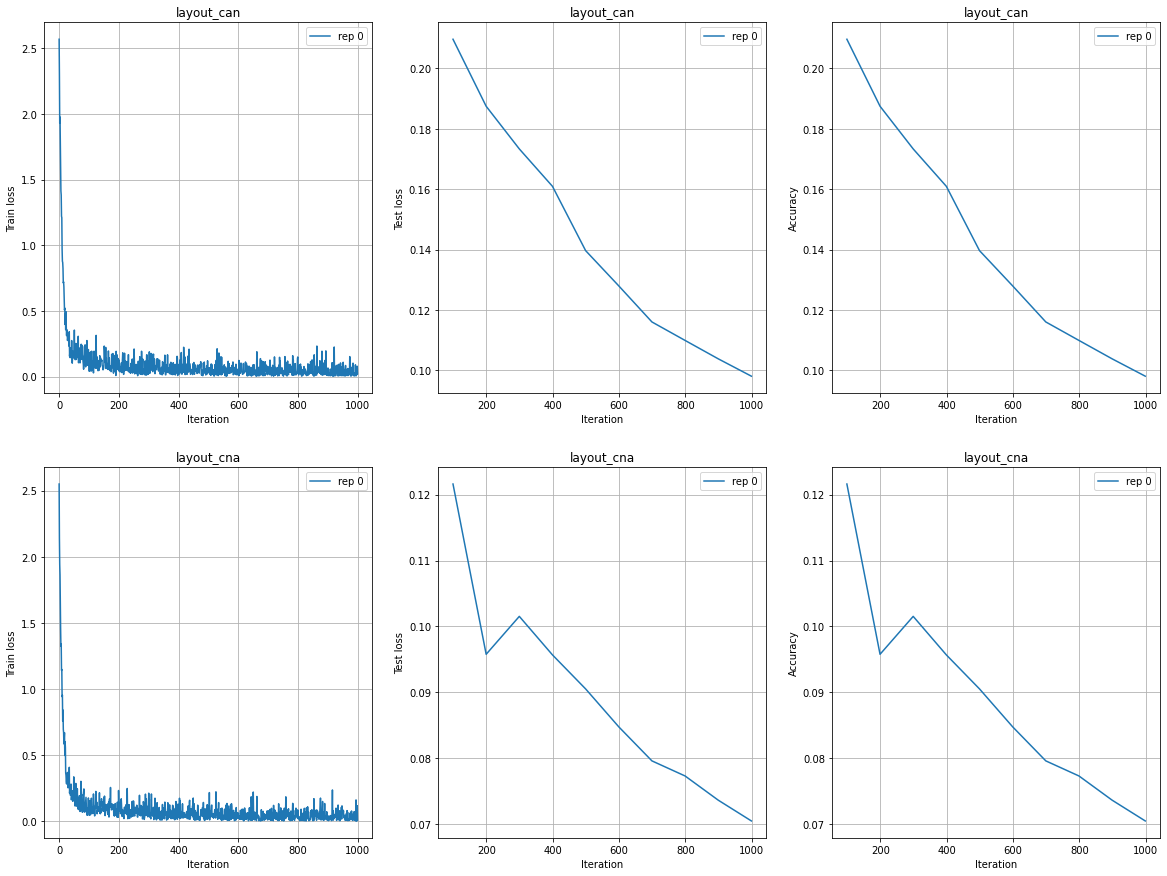

In [26]:
from batchflow.research.utils import plot_results_by_config

import numpy as np

plot_results_by_config(df, ['train_loss', 'test_loss', 'accuracy'],
                       figsize=(20, 15))